In [1]:
import opensmile
import pandas as pd
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


import audiofile

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


### Ravdess Dataframe

In [2]:
# Paths for data.
Ravdess = r'data'

#Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        #file_path.append(Ravdess + dir + '/' + file)
        file_path.append(os.path.join(Ravdess, dir, file))
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(15)

,Emotions,Path
0,neutral,data\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,data\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,data\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,data\Actor_01\03-01-01-01-02-02-01.wav
4,calm,data\Actor_01\03-01-02-01-01-01-01.wav
5,calm,data\Actor_01\03-01-02-01-01-02-01.wav
6,calm,data\Actor_01\03-01-02-01-02-01-01.wav
7,calm,data\Actor_01\03-01-02-01-02-02-01.wav
8,calm,data\Actor_01\03-01-02-02-01-01-01.wav
9,calm,data\Actor_01\03-01-02-02-01-02-01.wav


In [4]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,data\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,data\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,data\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,data\Actor_01\03-01-01-01-02-02-01.wav
4,calm,data\Actor_01\03-01-02-01-01-01-01.wav


### Data Visualisation and Exploration

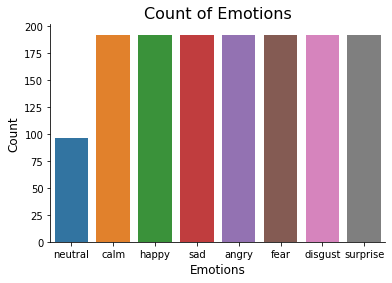

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

##### Extract features from a python wrapper

In [6]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [8]:
# files = data_path['Path'].iloc[0]  # pick files
# smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.eGeMAPSv02,
#     feature_level=opensmile.FeatureLevel.Functionals,
# )
# smile.process_files(
#     files,
#     ends=['2s'] * len(files),
#     root=db.root,
# )

In [9]:
file = data_path['Path'].iloc[0]
signal, sampling_rate = audiofile.read(
    file,
    duration=10,
    always_2d=True,
)

In [10]:
signal.shape

(1, 158558)

In [11]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
smile.feature_names

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNorm',
 'mfcc4_

In [13]:
smile.process_signal(
    signal,
    sampling_rate
).iloc[0].values.shape

(88,)

In [42]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def get_features(path):
    signal, sampling_rate = audiofile.read(path,
    duration=10,
    always_2d=True)
    
    features_df = smile.process_signal(signal, sampling_rate)
    features = features_df.iloc[0].values
    features = np.expand_dims(features, axis=0)
    return features


##### feature extractor for low-level descriptors (LLDs).

In [ ]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
smile.process_signal(
    signal,
    sampling_rate
)

### Normalizing and splitting the data for training and testing

In [43]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    #print(path)
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)


data\Actor_01\03-01-01-01-01-01-01.wav
data\Actor_01\03-01-01-01-01-02-01.wav
data\Actor_01\03-01-01-01-02-01-01.wav
data\Actor_01\03-01-01-01-02-02-01.wav
data\Actor_01\03-01-02-01-01-01-01.wav
data\Actor_01\03-01-02-01-01-02-01.wav
data\Actor_01\03-01-02-01-02-01-01.wav
data\Actor_01\03-01-02-01-02-02-01.wav
data\Actor_01\03-01-02-02-01-01-01.wav
data\Actor_01\03-01-02-02-01-02-01.wav
data\Actor_01\03-01-02-02-02-01-01.wav
data\Actor_01\03-01-02-02-02-02-01.wav
data\Actor_01\03-01-03-01-01-01-01.wav
data\Actor_01\03-01-03-01-01-02-01.wav
data\Actor_01\03-01-03-01-02-01-01.wav
data\Actor_01\03-01-03-01-02-02-01.wav
data\Actor_01\03-01-03-02-01-01-01.wav
data\Actor_01\03-01-03-02-01-02-01.wav
data\Actor_01\03-01-03-02-02-01-01.wav
data\Actor_01\03-01-03-02-02-02-01.wav
data\Actor_01\03-01-04-01-01-01-01.wav
data\Actor_01\03-01-04-01-01-02-01.wav
data\Actor_01\03-01-04-01-02-01-01.wav
data\Actor_01\03-01-04-01-02-02-01.wav
data\Actor_01\03-01-04-02-01-01-01.wav
data\Actor_01\03-01-04-02

In [45]:
len(X), len(Y), data_path.Path.shape

(1440, 1440, (1440,))

In [46]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,labels
0,24.263882,0.104171,21.653507,23.907377,27.101028,5.447521,104.436607,113.437279,31.389975,8.258446,...,0.011220,0.005713,2.127660,0.925926,0.336667,0.226912,0.540000,0.480260,-47.939644,neutral
1,25.167887,0.103561,23.178244,25.003677,27.699860,4.521616,56.695068,18.043522,9.703037,9.479506,...,0.012741,0.005434,2.409639,1.223242,0.257500,0.089826,0.535000,0.485206,-47.342331,neutral
2,24.186604,0.103495,22.353910,23.728384,27.093285,4.739374,209.152679,255.810944,13.067581,11.153270,...,0.014029,0.007729,2.153846,0.630915,0.545000,0.175000,0.676667,0.414836,-45.849762,neutral
3,24.268759,0.096042,22.443832,24.478970,26.744179,4.300346,159.005051,128.233871,31.331650,10.120676,...,0.012169,0.008324,2.222222,0.977199,0.333333,0.267374,0.500000,0.445702,-46.193146,neutral
4,24.898130,0.117897,22.419266,24.678062,28.138033,5.718767,214.876053,234.977615,32.979195,25.259745,...,0.010664,0.007934,2.840909,1.440922,0.182000,0.116172,0.408333,0.441717,-50.563885,calm


In [47]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [48]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [49]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 88), (1080, 8), (360, 88), (360, 8))

In [50]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 88), (1080, 8), (360, 88), (360, 8))

In [51]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 88, 1), (1080, 8), (360, 88, 1), (360, 8))

### Modelling

In [52]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 88, 256)           1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 44, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 44, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 22, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 22, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 11, 128)         

In [53]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
17/17 [==============================] - 2s 71ms/step - loss: 2.0857 - accuracy: 0.1407 - val_loss: 2.0626 - val_accuracy: 0.1472 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 1s 66ms/step - loss: 2.0289 - accuracy: 0.1704 - val_loss: 1.9929 - val_accuracy: 0.1889 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 1s 63ms/step - loss: 1.9594 - accuracy: 0.2259 - val_loss: 1.9500 - val_accuracy: 0.2889 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 1s 64ms/step - loss: 1.9374 - accuracy: 0.2315 - val_loss: 1.9165 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 1s 66ms/step - loss: 1.8870 - accuracy: 0.2389 - val_loss: 1.8468 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 1s 64ms/step - loss: 1.8676 - accuracy: 0.2352 - val_loss: 1.8272 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 1s 67ms/step - loss: 1.8

12/12 [==============================] - 0s 9ms/step - loss: 1.7035 - accuracy: 0.5139
Accuracy of our model on test data :  51.38888955116272 %


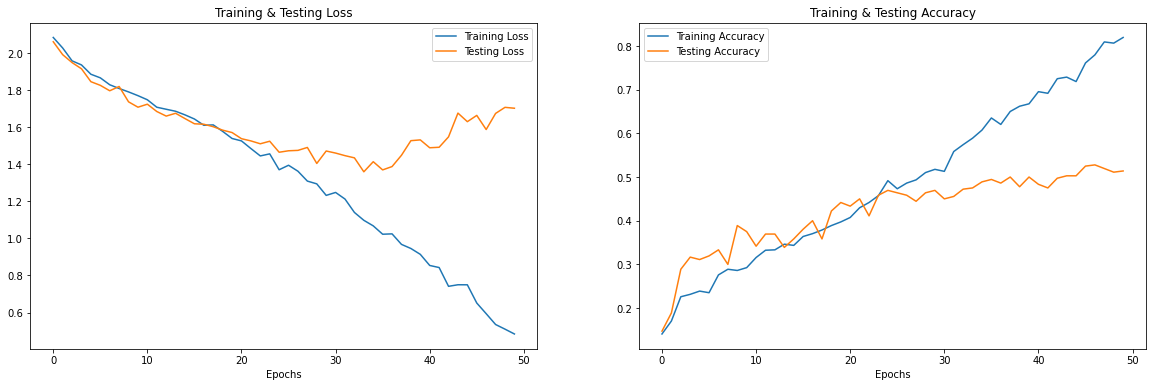

In [54]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [55]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [56]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,angry,angry
1,fear,fear
2,surprise,surprise
3,angry,angry
4,happy,sad
5,neutral,calm
6,calm,calm
7,surprise,fear
8,neutral,disgust
9,disgust,disgust


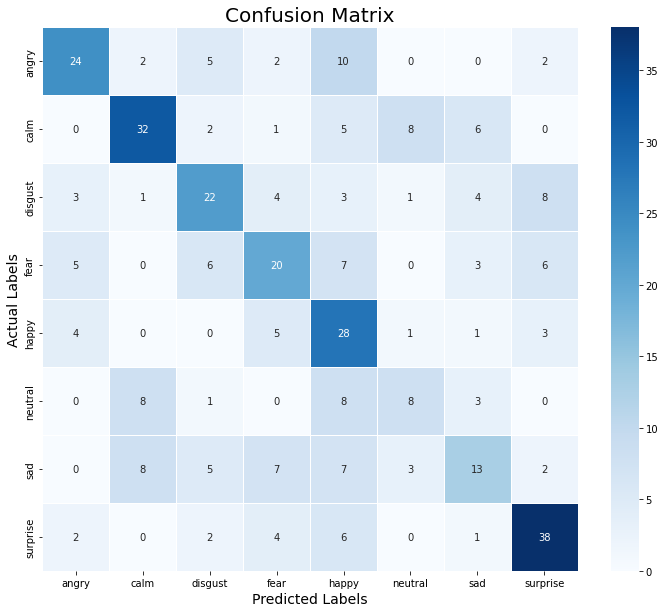

In [57]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.53      0.58        45
        calm       0.63      0.59      0.61        54
     disgust       0.51      0.48      0.49        46
        fear       0.47      0.43      0.44        47
       happy       0.38      0.67      0.48        42
     neutral       0.38      0.29      0.33        28
         sad       0.42      0.29      0.34        45
    surprise       0.64      0.72      0.68        53

    accuracy                           0.51       360
   macro avg       0.51      0.50      0.49       360
weighted avg       0.52      0.51      0.51       360

